# TP INDEXATION AVEC HACHAGE
LOUGBEGNON AMEDEE ||
TOUMBA NGONGO CHRISTINE

In [13]:
!pip install -U scikit-learn scipy matplotlib

You should consider upgrading via the '/Users/lougbegnonamedee/Documents/tp_hashage/env/bin/python3 -m pip install --upgrade pip' command.


Clustering 557527 descripteurs en 500 clusters...
✅ Frame sélectionnée avec 2735 keypoints.


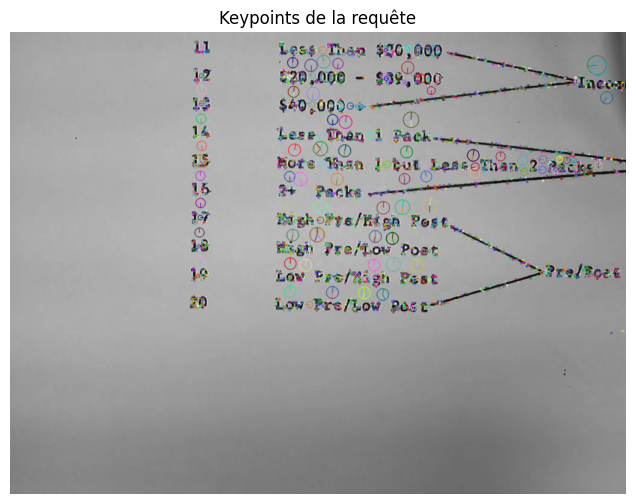

📄 Document reconnu: 0055.jpg


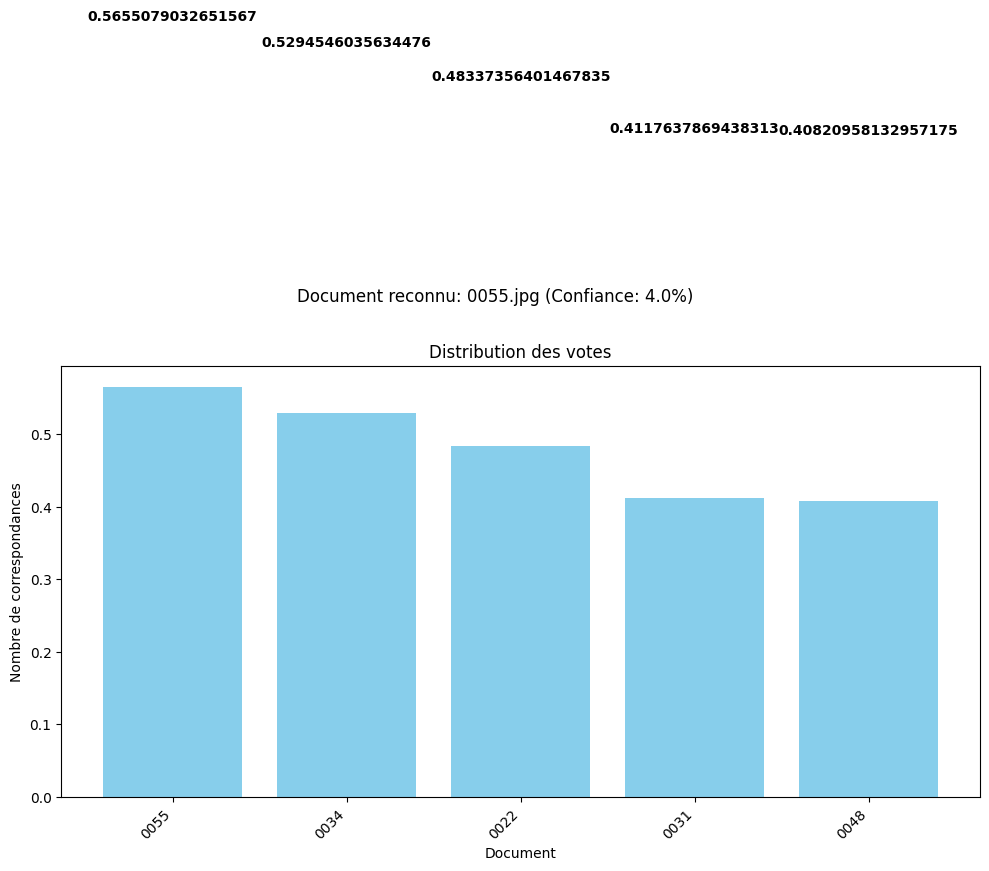

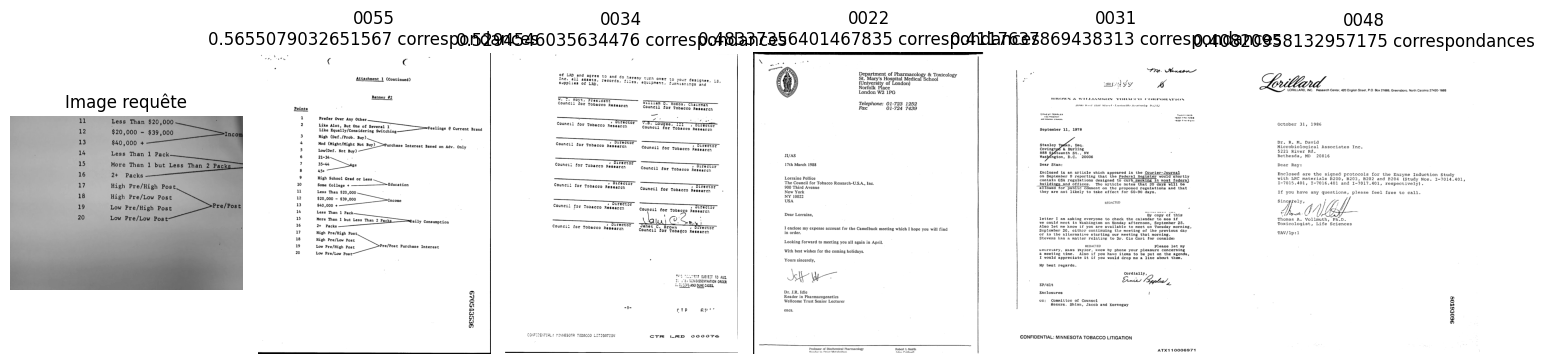

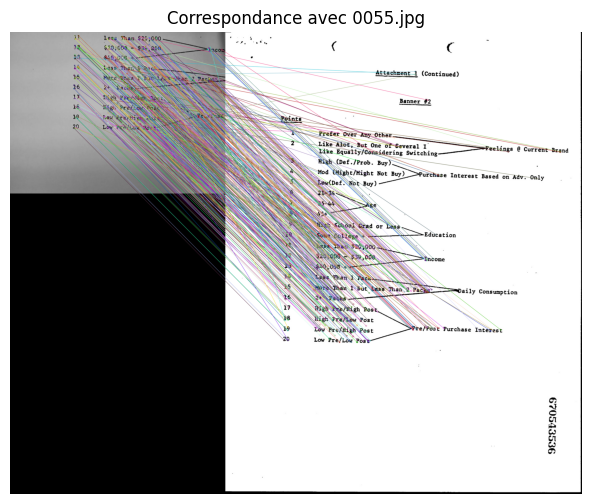

In [14]:
import cv2
import numpy as np
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine

# --- SIFT extractor ---
sift = cv2.SIFT_create()

def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return image, keypoints, descriptors

# --- Chargement dataset ---
def load_dataset_features(folder_path):
    features = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img, kp, des = extract_sift_features(path)
            features[filename] = {'image': img, 'keypoints': kp, 'descriptors': des}
    return features

# --- Extraire une frame depuis une vidéo ---
def extract_best_frame_from_video(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    best_frame = None
    max_keypoints = 0
    
    sift = cv2.SIFT_create()

    for i in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints, _ = sift.detectAndCompute(gray, None)

        if keypoints is not None and len(keypoints) > max_keypoints:
            max_keypoints = len(keypoints)
            best_frame = gray

    cap.release()

    if best_frame is not None:
        print(f"✅ Frame sélectionnée avec {max_keypoints} keypoints.")
        return best_frame
    else:
        print("❌ Aucune frame valable trouvée.")
        return None


# --- Affichage keypoints ---
def show_keypoints(image, keypoints, title="Keypoints"):
    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.imshow(img_kp, cmap='gray')
    plt.axis('off')
    plt.show()

# --- Construction du vocabulaire visuel ---
def build_codebook(descriptors_list, num_clusters=100):
    all_descriptors = np.vstack(descriptors_list)
    print(f"Clustering {all_descriptors.shape[0]} descripteurs en {num_clusters} clusters...")
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=0)
    kmeans.fit(all_descriptors)
    return kmeans

# --- Index inversé avec hachage ---
def build_inverted_index(dataset_features, codebook):
    inverted_index = defaultdict(list)
    image_histograms = {}
    
    for image_name, data in dataset_features.items():
        if data['descriptors'] is None:
            continue
        words = codebook.predict(data['descriptors'])
        image_histograms[image_name] = Counter(words)
        for word in set(words):
            inverted_index[word].append(image_name)
    
    return inverted_index, image_histograms

def query_with_hash_table(query_des, codebook, inverted_index, image_histograms):
    query_words = codebook.predict(query_des)
    query_hist = Counter(query_words)

    # Convertir en vecteur
    vocab_size = codebook.n_clusters
    query_vector = np.zeros(vocab_size)
    for idx, count in query_hist.items():
        query_vector[idx] = count
    query_vector = normalize(query_vector.reshape(1, -1))[0]

    scores = {}
    for img_name, hist in image_histograms.items():
        doc_vector = np.zeros(vocab_size)
        for idx, count in hist.items():
            doc_vector[idx] = count
        doc_vector = normalize(doc_vector.reshape(1, -1))[0]
        
        # Similarité cosinus (plus proche de 1 = meilleur)
        similarity = 1 - cosine(query_vector, doc_vector)
        scores[img_name] = similarity

    return Counter(scores)


# --- Visualisation des votes ---
def visualize_votes(match_counts, title="Distribution des votes"):
    if not isinstance(match_counts, Counter):
        match_counts = Counter(match_counts)
        
    top_matches = match_counts.most_common(min(5, len(match_counts)))
    
    if not top_matches:
        print("Aucun vote à afficher.")
        return
    
    labels = [os.path.splitext(name)[0] for name, _ in top_matches]
    counts = [count for _, count in top_matches]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(labels)), counts, color='skyblue')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(title)
    plt.xlabel('Document')
    plt.ylabel('Nombre de correspondances')
    
    total_votes = sum(match_counts.values())
    if total_votes > 0 and top_matches:
        confidence = (top_matches[0][1] / total_votes) * 100
        plt.suptitle(f"Document reconnu: {top_matches[0][0]} (Confiance: {confidence:.1f}%)")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# --- Grille des meilleures correspondances ---
def show_top_matches_grid(query_img, query_kp, query_des, dataset_features, match_counts, top_n=9):
    top_matches = Counter(match_counts).most_common(top_n)
    
    if not top_matches:
        print("Aucun match à afficher.")
        return
    
    fig, axes = plt.subplots(1, top_n+1, figsize=(15, 5))
    
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title("Image requête")
    axes[0].axis('off')
    
    for i, (img_name, count) in enumerate(top_matches, 1):
        if i <= top_n:
            data = dataset_features[img_name]
            axes[i].imshow(data['image'], cmap='gray')
            axes[i].set_title(f"{os.path.splitext(img_name)[0]}\n{count} correspondances")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Affichage détaillé de la meilleure correspondance ---
def show_best_match(query_img, query_kp, query_des, dataset_features, best_match_name):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    best_data = dataset_features[best_match_name]
    matches = flann.knnMatch(query_des, best_data['descriptors'], k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    match_img = cv2.drawMatchesKnn(query_img, query_kp,
                                    best_data['image'], best_data['keypoints'],
                                    [[m] for m in good], None, flags=2)

    plt.figure(figsize=(12, 6))
    plt.title(f"Correspondance avec {best_match_name}")
    plt.imshow(match_img)
    plt.axis('off')
    plt.show()

# --- Démo d'exécution ---
dataset_folder = "images"
video_path = "requetes/55-BL.mp4"

# 1. Indexation des images
dataset_features = load_dataset_features(dataset_folder)

# 1.1 Extraction de tous les descripteurs pour KMeans
all_descriptors = [data['descriptors'] for data in dataset_features.values() if data['descriptors'] is not None]
codebook = build_codebook(all_descriptors, num_clusters=500)

# 1.2 Création de l'index inversé (hash table)
inverted_index, image_histograms = build_inverted_index(dataset_features, codebook)

# 2. Extraire une frame de la vidéo
query_img = extract_best_frame_from_video(video_path)
query_kp, query_des = sift.detectAndCompute(query_img, None)

# 3. Afficher les keypoints de la requête
show_keypoints(query_img, query_kp, title="Keypoints de la requête")

# 4. Recherche par hash table
match_counts = query_with_hash_table(query_des, codebook, inverted_index, image_histograms)
best_match = match_counts.most_common(1)[0][0] if match_counts else None
print("📄 Document reconnu:", best_match)

# 5. Visualisation des votes
visualize_votes(match_counts)

# 6. Grille des top correspondances
show_top_matches_grid(query_img, query_kp, query_des, dataset_features, match_counts, top_n=5)

# 7. Visualiser la meilleure correspondance en détail
if best_match:
    show_best_match(query_img, query_kp, query_des, dataset_features, best_match)
